<a href="https://colab.research.google.com/github/dmitry-kabanov/tensorflow-docs-walkthrough/blob/main/tutorials/structured_data/imbalanced_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification on imbalanced data

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [39]:
mpl.rcParams["figure.figsize"] = (12, 10)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

%config InlineBackend.figure_format = 'retina'

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv")
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Now let's analyze the dataset imbalance

In [5]:
neg, pos = np.bincount(raw_df["Class"])
total = neg + pos
print("Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)".format(
    total, pos, 100 * pos / total
))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)


### Clean, split and normalize the data

In [6]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop("Time")

# The `Amount` column covers a huge range. Convert to log scale.
eps = 0.001
cleaned_df["Log Amount"] = np.log(cleaned_df.pop("Amount") + eps)

In [7]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form ndarrays
train_labels = np.array(train_df.pop("Class"))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop("Class"))
test_labels = np.array(test_df.pop("Class"))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print("Training labels shape: ", train_labels.shape)
print("Validation labels shape: ", val_labels.shape)
print("Test labels shape: ", test_labels.shape)

print("Training features shape: ", train_features.shape)
print("Validation features shape: ", val_features.shape)
print("Test features shape: ", test_features.shape)

Training labels shape:  (182276,)
Validation labels shape:  (45569,)
Test labels shape:  (56962,)
Training features shape:  (182276, 29)
Validation features shape:  (45569, 29)
Test features shape:  (56962, 29)


### Look at the data distribution

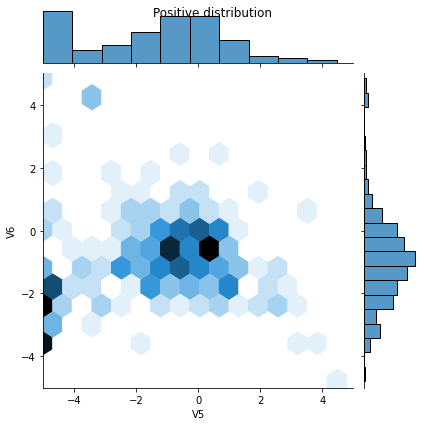

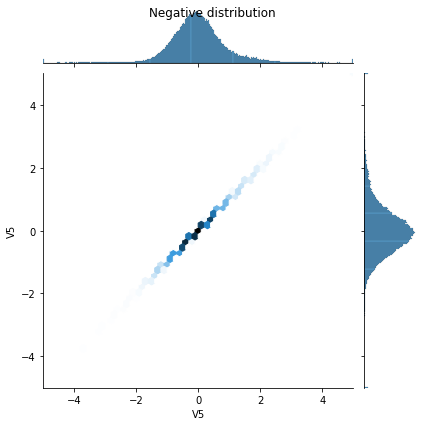

In [9]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df["V5"], y=pos_df["V6"],
              kind="hex", xlim=(-5, 5), ylim=(-5, 5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df["V5"], y=neg_df["V5"],
              kind="hex", xlim=(-5, 5), ylim=(-5, 5))
_ = plt.suptitle("Negative distribution")


In [10]:
### Define the model and metrics

In [11]:
metrics = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
    keras.metrics.AUC(name="prc", curve="PR")  # Precision-recall curve
]

In [12]:
def make_model(metrics=metrics, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)

    model = keras.Sequential([
        keras.layers.Dense(16, activation="relu",
                           input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(
            1, activation="sigmoid", bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

### Understanding useful metrics

There are different metrics defined above. Note that accuracy is not a helpful metric here. Due to the imbalance in the classes, you can get 99.8% accuracy just by predicting negative classes unconditionally.

## Baseline model

In [13]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_prc",
    verbose=1,
    patience=10,
    mode="max",
    restore_best_weights=True
)

In [14]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.predict(train_features[:10])

array([[0.9011283 ],
       [0.8649647 ],
       [0.82017523],
       [0.85722244],
       [0.90804005],
       [0.8632219 ],
       [0.92480826],
       [0.7166922 ],
       [0.7494514 ],
       [0.77544653]], dtype=float32)

With the default bias initialization, the loss is about math.log(2):

In [16]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.9474


In [17]:
initial_bias = np.log(pos/neg)
initial_bias

-6.359359340922742

In [18]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00826272],
       [0.00262445],
       [0.00318277],
       [0.00170943],
       [0.00235054],
       [0.0024741 ],
       [0.00111648],
       [0.00334626],
       [0.00096276],
       [0.00149402]], dtype=float32)

In [19]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE)
print("Loss: {:0.4f}".format(results[0]))

90/90 [==============================] - 3s 5ms/step - loss: 0.0122 - tp: 305.0000 - fp: 180788.0000 - tn: 183154.0000 - fn: 305.0000 - accuracy: 0.5032 - precision: 0.0017 - recall: 0.5000 - auc: 0.6342 - prc: 0.0410
Loss: 0.0122


### Checkpoint the initial weights

In [20]:
initial_weights = os.path.join(tempfile.mkdtemp(), "initial_weights")
model.save_weights(initial_weights)

### Confirm that the bias fix helps

In [21]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0
)

In [22]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0
)

In [23]:
def plot_loss(history, label, n):
    plt.semilogy(
        history.epoch,
        history.history["loss"],
        color=colors[n], label="Train " + label
    )
    plt.semilogy(
        history.epoch,
        history.history["val_loss"], "--",
        color=colors[n], label="Val " + label
    )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")


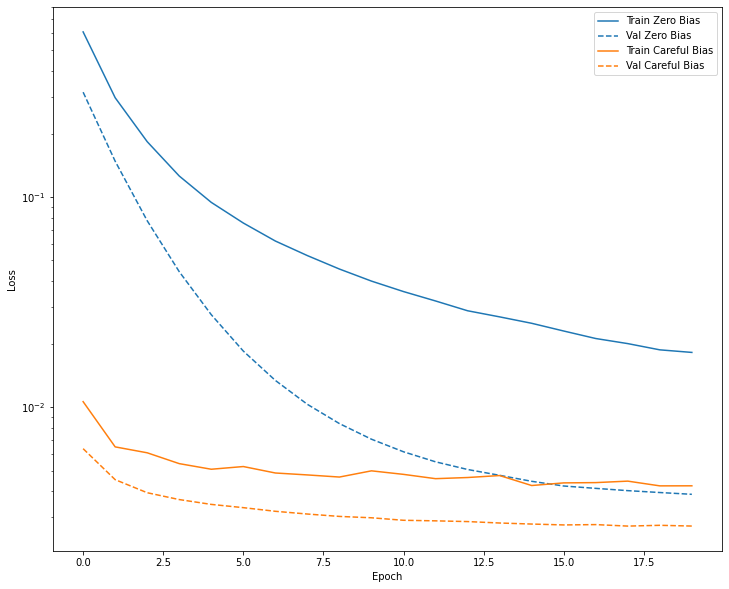

In [24]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)
plt.legend(loc="best")

### Train the model

In [25]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels)
)

Epoch 1/100
90/90 [==============================] - 4s 18ms/step - loss: 0.0110 - tp: 91.0000 - fp: 26.0000 - tn: 227432.0000 - fn: 296.0000 - accuracy: 0.9986 - precision: 0.7778 - recall: 0.2351 - auc: 0.7661 - prc: 0.3011 - val_loss: 0.0069 - val_tp: 7.0000 - val_fp: 1.0000 - val_tn: 45486.0000 - val_fn: 75.0000 - val_accuracy: 0.9983 - val_precision: 0.8750 - val_recall: 0.0854 - val_auc: 0.9138 - val_prc: 0.7147
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0073 - tp: 86.0000 - fp: 19.0000 - tn: 181952.0000 - fn: 219.0000 - accuracy: 0.9987 - precision: 0.8190 - recall: 0.2820 - auc: 0.8601 - prc: 0.4578 - val_loss: 0.0046 - val_tp: 38.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 44.0000 - val_accuracy: 0.9989 - val_precision: 0.8837 - val_recall: 0.4634 - val_auc: 0.9324 - val_prc: 0.7538
Epoch 3/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0061 - tp: 135.0000 - fp: 27.0000 - tn: 181944.0000 - fn: 170.0000 - accuracy: 0.

### Check training history

In [26]:
def plot_metrics(history):
    metrics = ["loss", "prc", "precision", "recall"]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(
            history.epoch, history.history[metric],
            color=colors[0], label="Train")
        plt.plot(
            history.epoch, history.history["val_"+metric],
            "--", color=colors[0], label="Val"
        )
        if metric == "loss":
            plt.gca().set_yscale("log")
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            # plt.ylim([1e-16, plt.ylim()[1]])
            pass
        elif metric == "auc":
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend();

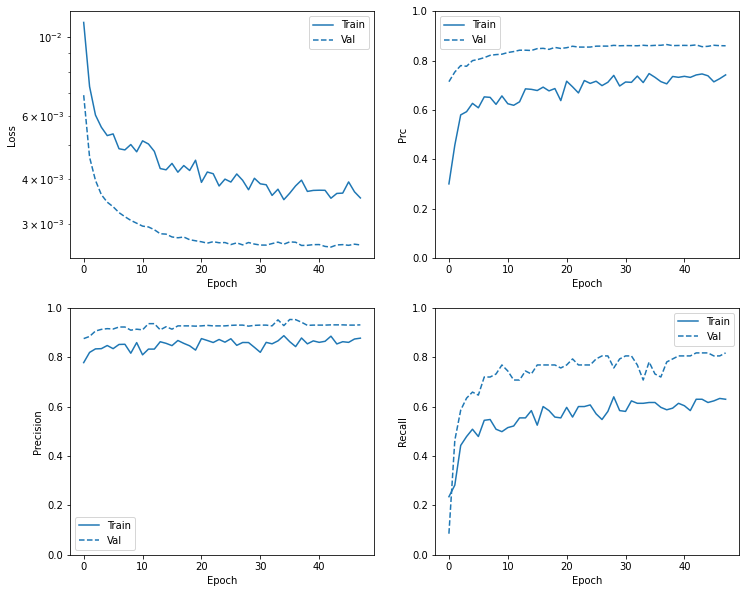

In [27]:
plot_metrics(baseline_history)

### Evaluate metric

In [28]:
train_pred_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_pred_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [29]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(p))
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    print("Legitimate Transactions detected (TN): ", cm[0, 0])
    print("Legitimate tnxns incorrectly detecte (FP): ", cm[0, 1])
    print("Fraudulent tnxns missed (FN): ", cm[1, 0])
    print("Fraudulent tnxns detected (TP): ", cm[1, 1])
    print("Total fraudulent tnxns: ", np.sum(cm[1]))

loss :  0.0031403328757733107
tp :  81.0
fp :  8.0
tn :  56849.0
fn :  24.0
accuracy :  0.9994382262229919
precision :  0.9101123809814453
recall :  0.7714285850524902
auc :  0.932975709438324
prc :  0.8336118459701538

Legitimate Transactions detected (TN):  56849
Legitimate tnxns incorrectly detecte (FP):  8
Fraudulent tnxns missed (FN):  24
Fraudulent tnxns detected (TP):  81
Total fraudulent tnxns:  105


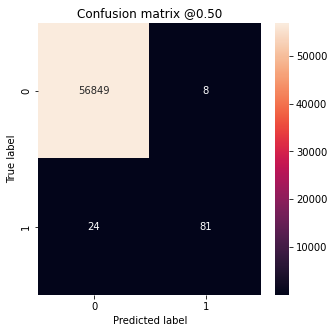

In [30]:
baseline_results = model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE,
    verbose=0
)

for name, value in zip(model.metrics_names, baseline_results):
    print(name, ": ", value)
print()

plot_cm(test_labels, test_pred_baseline)

### Plot the ROC

Now we plot the Receiver Operating Curve (ROC) to understand how the performance of the model changes when we change the threshold that separates negative class from positive class (when we map the continuous [0; 1] output of the model to the discrete set {0, 1}).

In [33]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel("False positives [%]")
    plt.ylabel("True positives [%]")
    plt.xlim([-0.5, 20.0])
    plt.ylim([80.0, 100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")

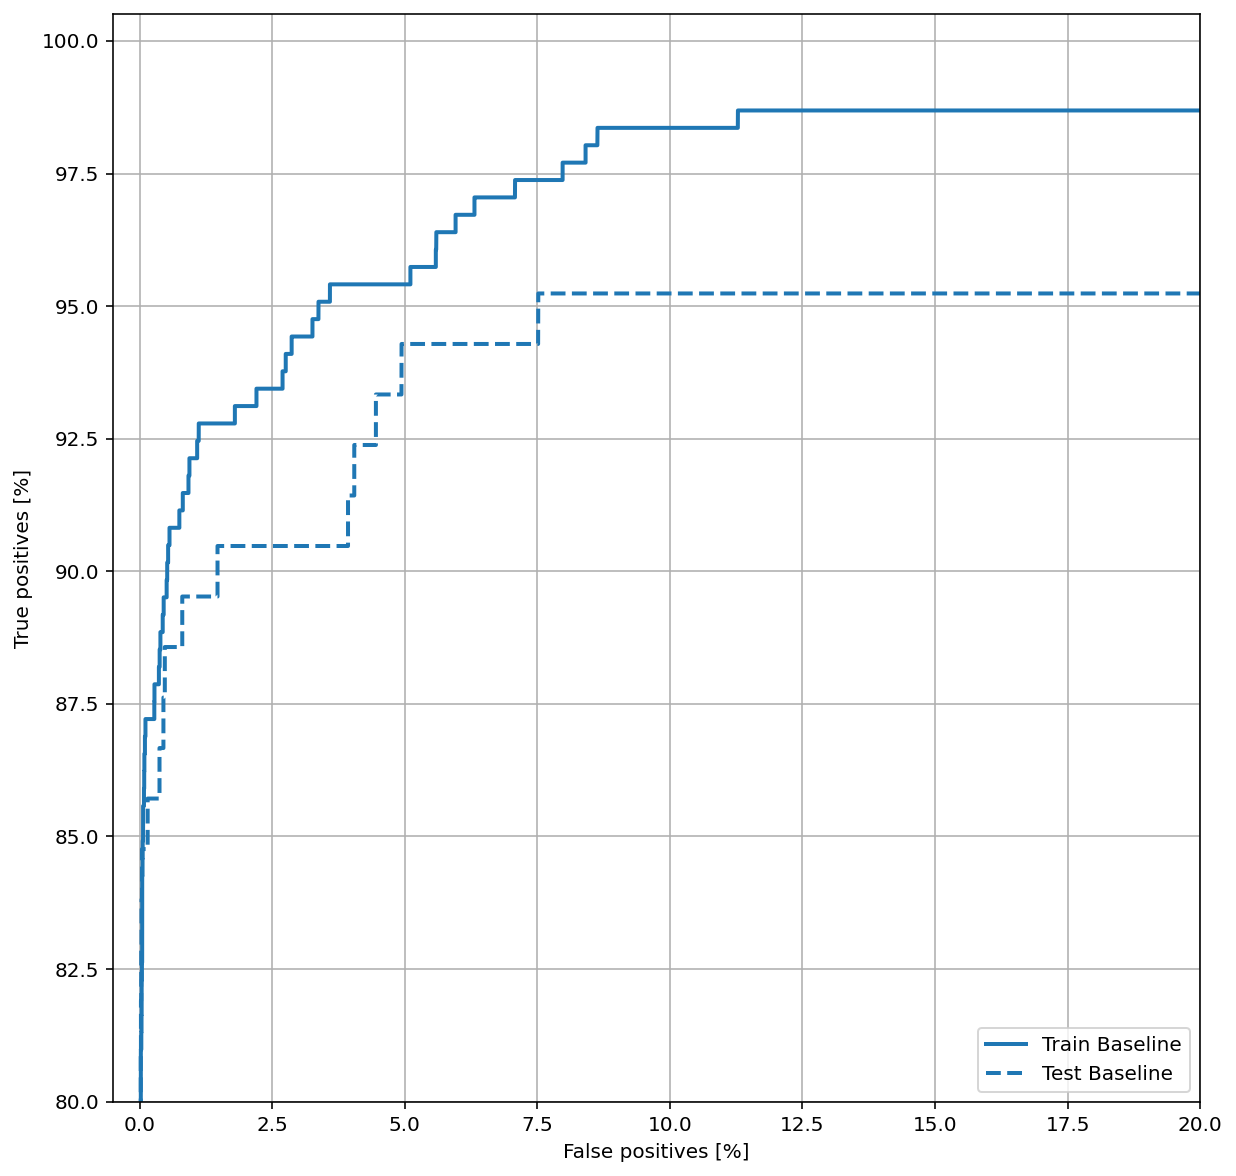

In [40]:
plot_roc("Train Baseline", train_labels, train_pred_baseline, color=colors[0], linestyle="-")
plot_roc("Test Baseline", test_labels, test_pred_baseline, color=colors[0], linestyle="--")
plt.legend(loc="lower right");

### Plot the AUPRC

Now we plot the precision-recall curve which is obtained by varying the threshold and computing the corresponding metrics at these thresholds.

In [41]:
def plot_prc(name, labels, predictions, **kwargs):
    P, R, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(P, R, label=name, lw=2, **kwargs)
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect("equal")

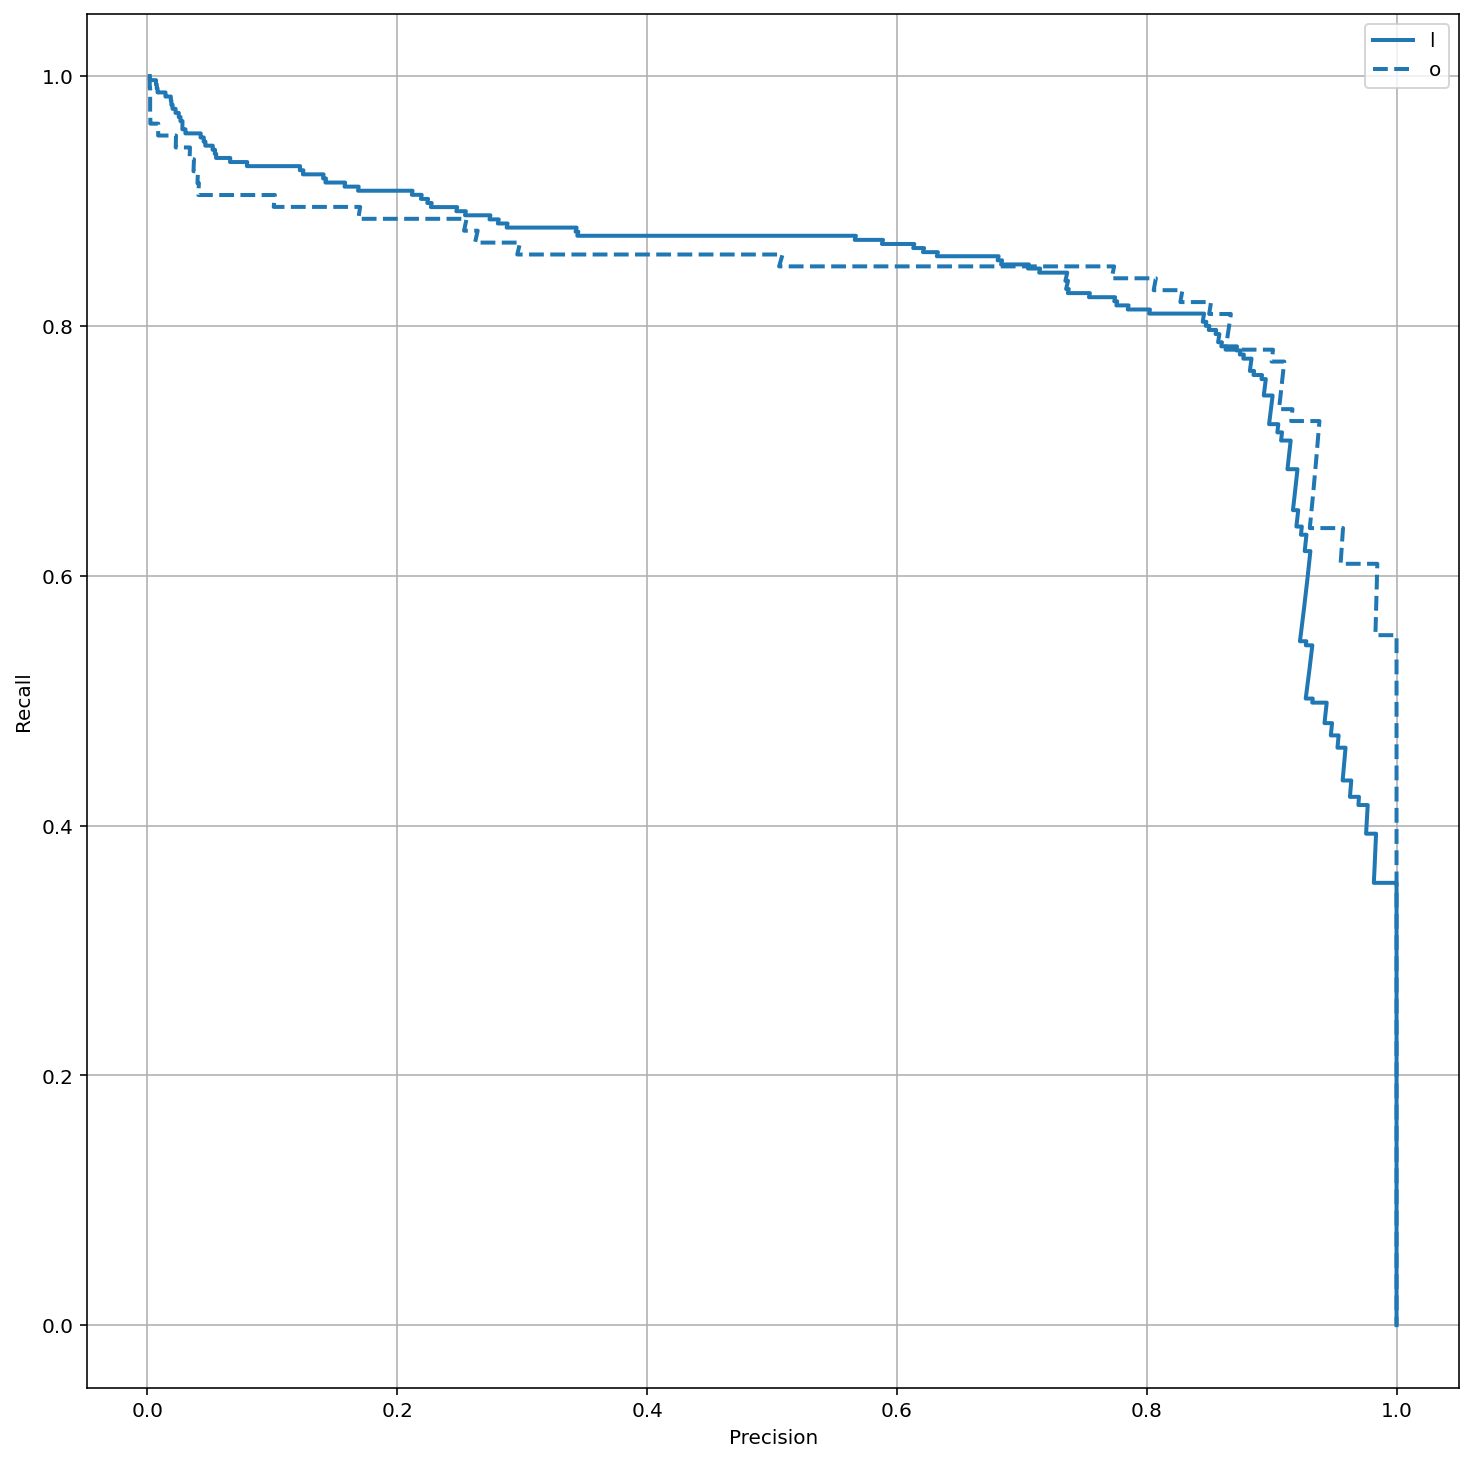

In [44]:
plot_prc("Train Baseline", train_labels, train_pred_baseline, color=colors[0], linestyle="-")
plot_prc("Test Baseline", test_labels, test_pred_baseline, color=colors[0], linestyle="--")
plt.legend("lower right");
plt.tight_layout(pad=0.1);

## Class weights

### Calculate class weights

In [45]:
weights_for_0 = (1 / neg) * (total / 2.0)
weights_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weights_for_0, 1: weights_for_1}

print("Weight for class 0: {:.2f}".format(weights_for_0))
print("Weight for class 1: {:.2f}".format(weights_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now we train a new model using weighted loss to see how it affects performance.

In [47]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here.
    class_weight=class_weight
)

Epoch 1/100
90/90 [==============================] - 6s 27ms/step - loss: 1.9213 - tp: 136.0000 - fp: 125.0000 - tn: 238703.0000 - fn: 274.0000 - accuracy: 0.9983 - precision: 0.5211 - recall: 0.3317 - auc: 0.7967 - prc: 0.3236 - val_loss: 0.0078 - val_tp: 40.0000 - val_fp: 5.0000 - val_tn: 45482.0000 - val_fn: 42.0000 - val_accuracy: 0.9990 - val_precision: 0.8889 - val_recall: 0.4878 - val_auc: 0.9422 - val_prc: 0.6892
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 0.9362 - tp: 152.0000 - fp: 398.0000 - tn: 181573.0000 - fn: 153.0000 - accuracy: 0.9970 - precision: 0.2764 - recall: 0.4984 - auc: 0.8806 - prc: 0.3664 - val_loss: 0.0099 - val_tp: 65.0000 - val_fp: 9.0000 - val_tn: 45478.0000 - val_fn: 17.0000 - val_accuracy: 0.9994 - val_precision: 0.8784 - val_recall: 0.7927 - val_auc: 0.9574 - val_prc: 0.7531
Epoch 3/100
90/90 [==============================] - 1s 9ms/step - loss: 0.6298 - tp: 195.0000 - fp: 1086.0000 - tn: 180885.0000 - fn: 110.0000 - accur

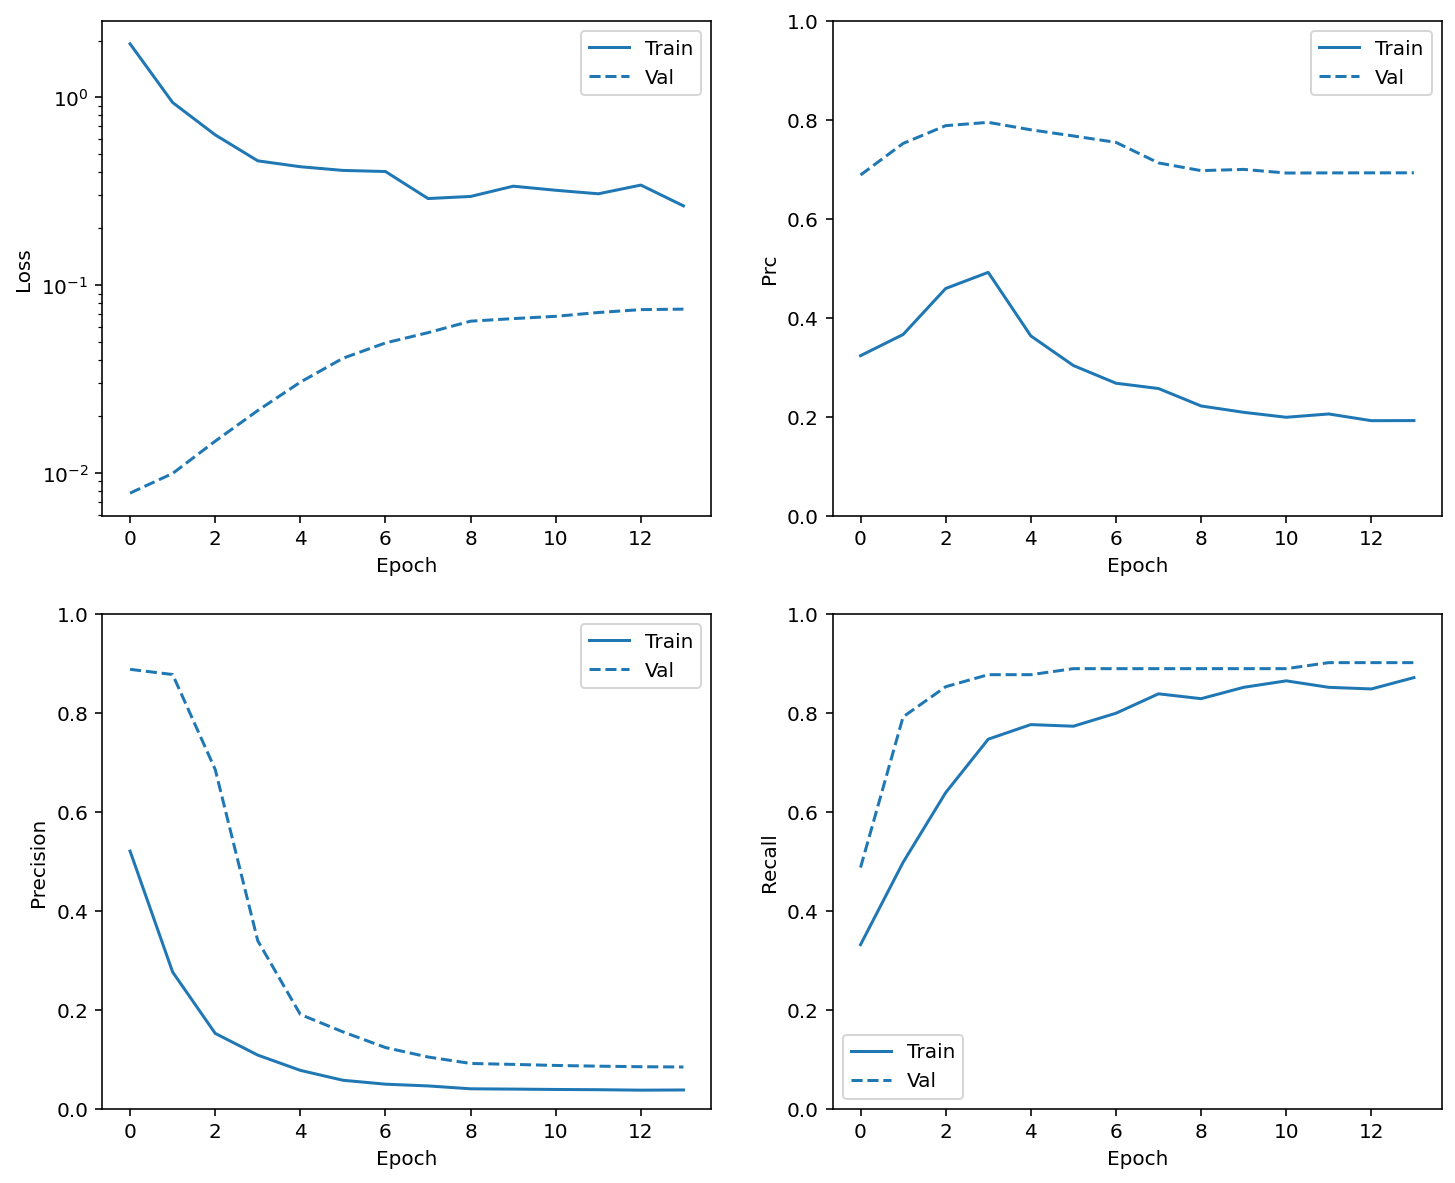

In [48]:
plot_metrics(weighted_history)

### Evaluate metrics

In [49]:
train_pred_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_pred_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

In [50]:
weighted_results = weighted_model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0
)

loss :  0.023683007806539536
tp :  89.0
fp :  157.0
tn :  56700.0
fn :  16.0
accuracy :  0.9969629049301147
precision :  0.36178863048553467
recall :  0.8476190567016602
auc :  0.9502641558647156
prc :  0.7152173519134521

Legitimate Transactions detected (TN):  56700
Legitimate tnxns incorrectly detecte (FP):  157
Fraudulent tnxns missed (FN):  16
Fraudulent tnxns detected (TP):  89
Total fraudulent tnxns:  105


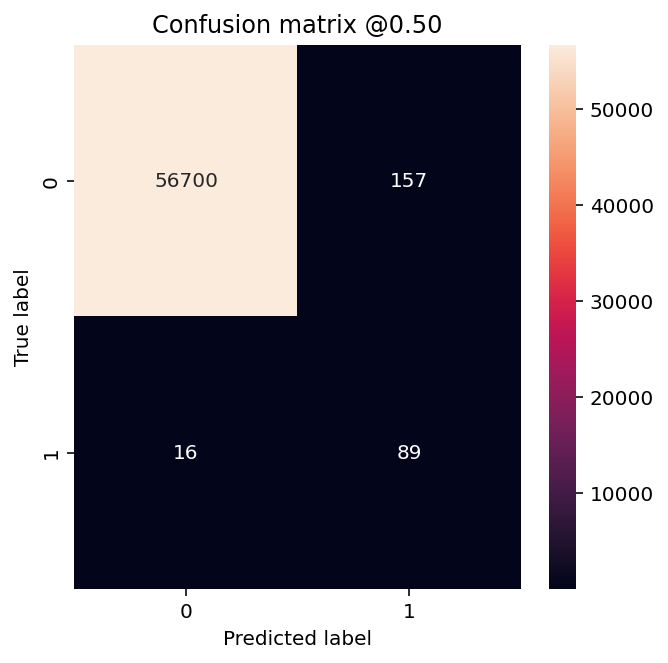

In [52]:
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ": ", value)
print()

plot_cm(test_labels, test_pred_weighted)

### Plot the ROC

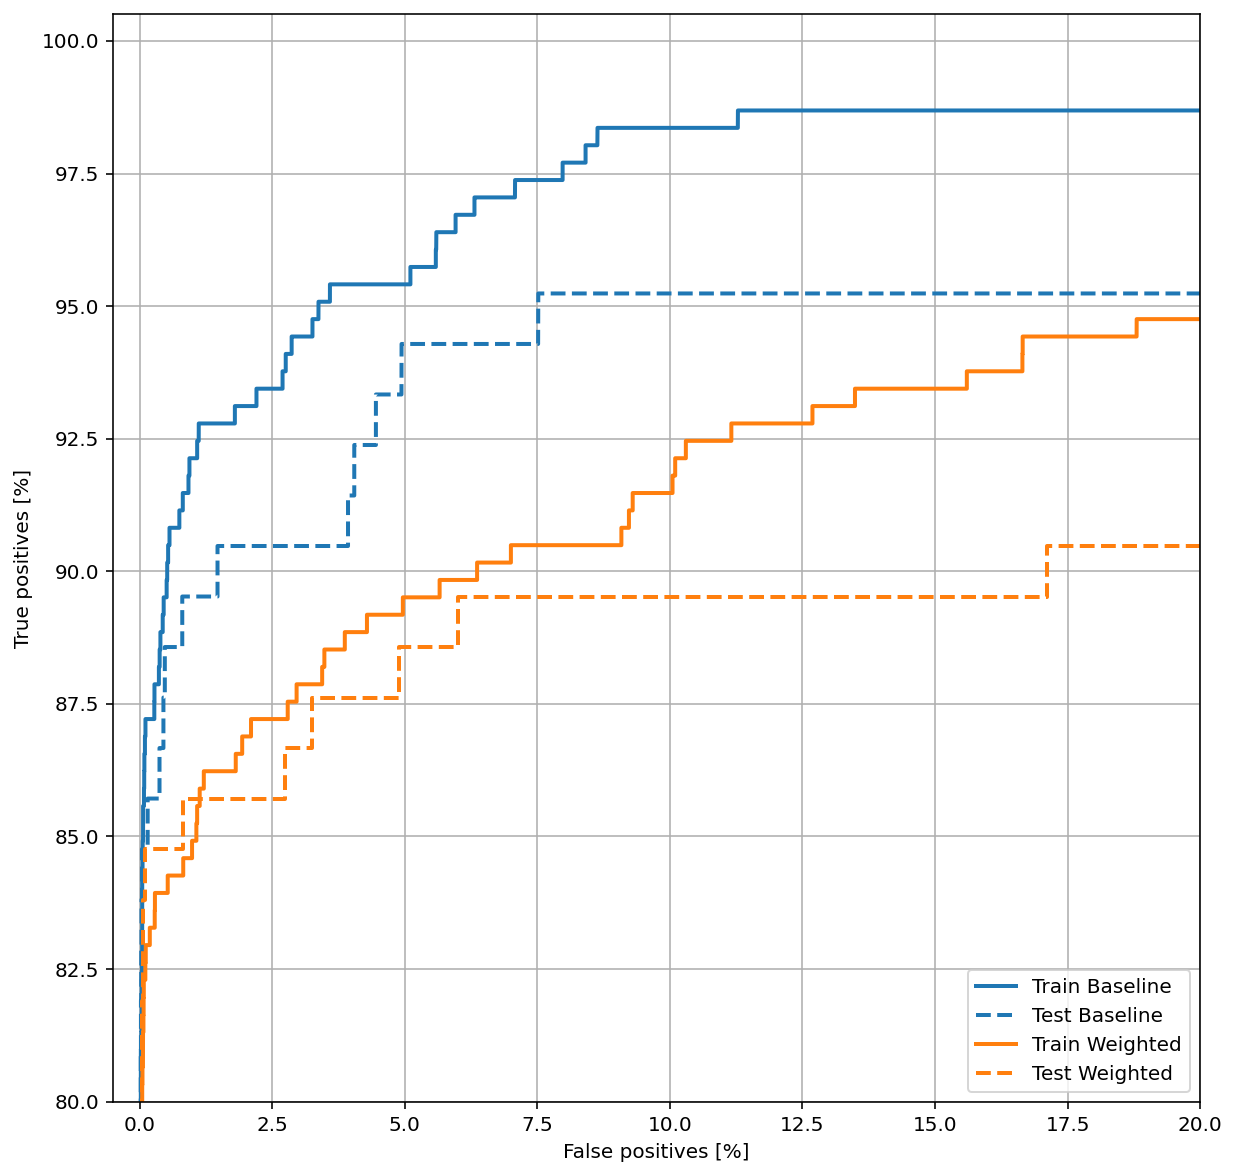

In [54]:
plot_roc("Train Baseline", train_labels, train_pred_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_pred_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_pred_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_pred_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');


### Plot the area under precision-recall curve

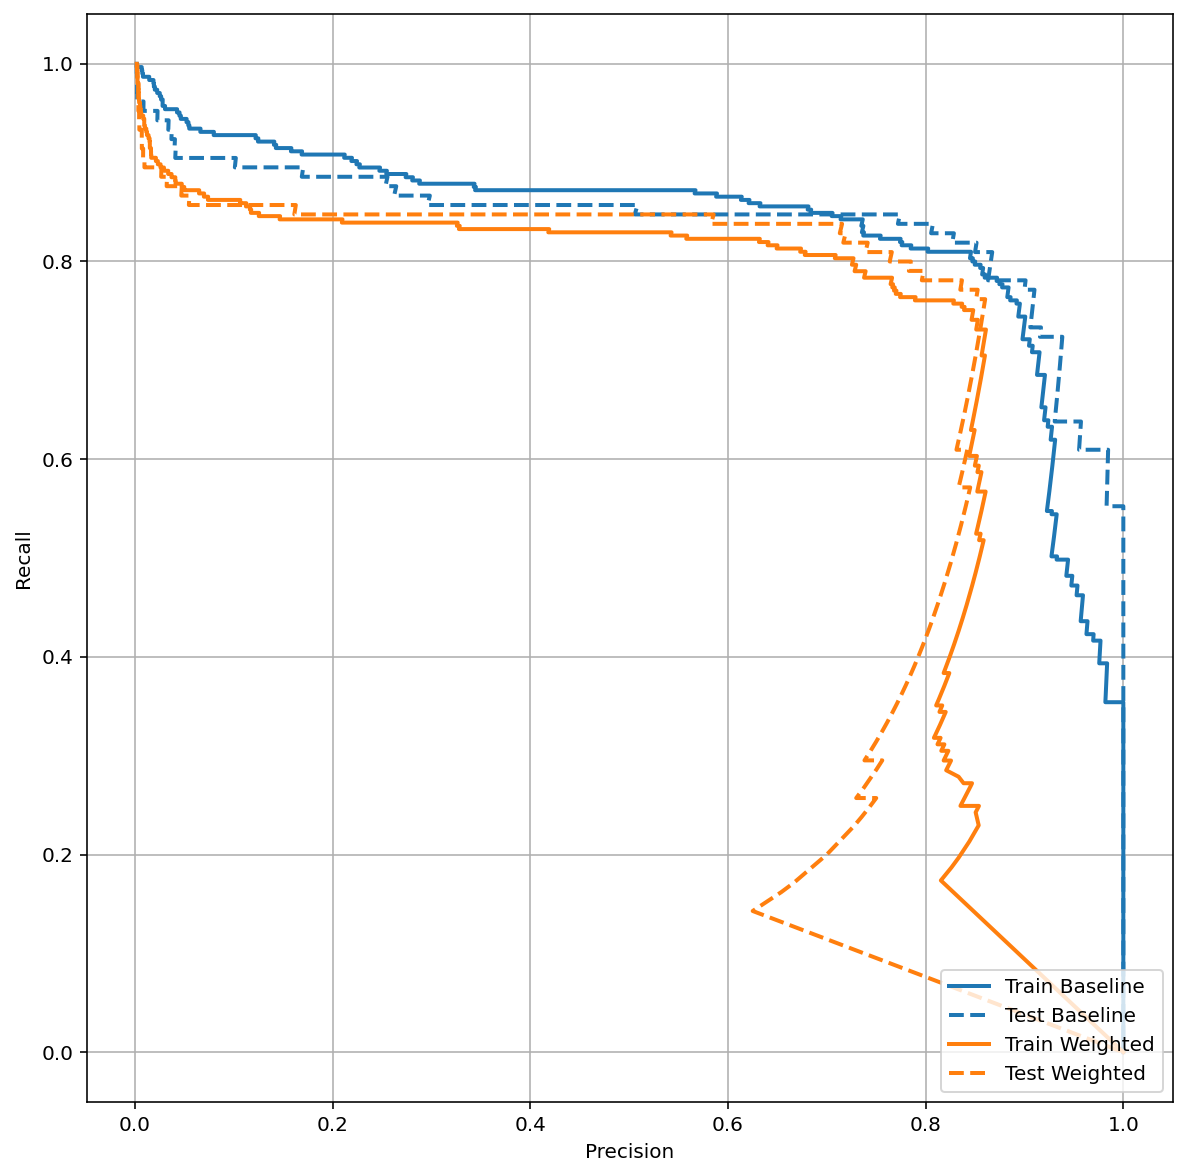

In [55]:
plot_prc("Train Baseline", train_labels, train_pred_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_pred_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_pred_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_pred_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

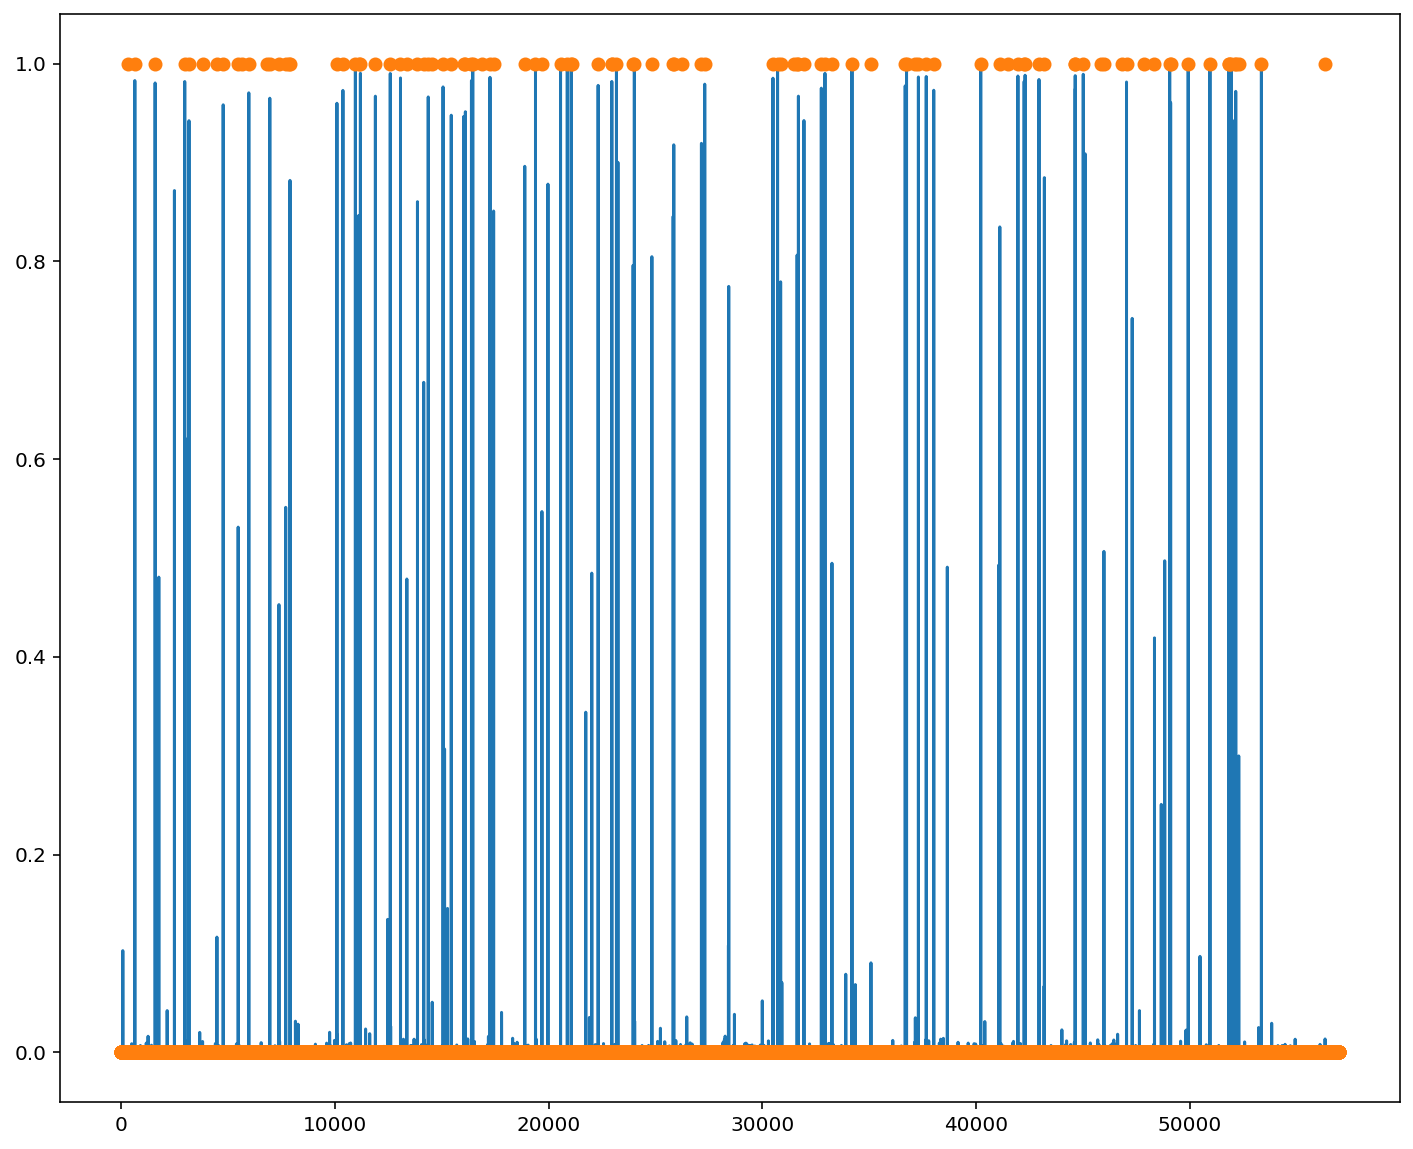

In [65]:
plt.plot(np.reshape(test_pred_baseline, -1))
plt.plot(test_labels, "o", color=colors[1])

In [61]:
test_labels.shape

(56962,)

## Oversampling

### Oversample the minority class

In [66]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [68]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [69]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [-1.19147026  1.34820023 -2.23198815  1.53793391 -2.57236675  0.23792609
 -1.39090642  1.21381837 -1.79667071 -5.          1.80134009 -4.56537606
  0.75238459 -5.         -0.13895302 -4.06716905 -5.         -3.21067886
 -0.55508372  0.3567199   1.05839291  0.40874089  0.48701581 -0.98658617
 -0.23539529 -1.01820993  1.72533942  0.62204921  1.55873376]

Label:  1


In [71]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [72]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.5068359375


In [73]:
resampled_steps_per_epoch = np.ceil(2.0 * neg / BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

In [74]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since the dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds
)

Epoch 1/100
278/278 [==============================] - 33s 107ms/step - loss: 0.3700 - tp: 248508.0000 - fp: 64318.0000 - tn: 277019.0000 - fn: 36461.0000 - accuracy: 0.8391 - precision: 0.7944 - recall: 0.8721 - auc: 0.9331 - prc: 0.9389 - val_loss: 0.1943 - val_tp: 75.0000 - val_fp: 1133.0000 - val_tn: 44354.0000 - val_fn: 7.0000 - val_accuracy: 0.9750 - val_precision: 0.0621 - val_recall: 0.9146 - val_auc: 0.9685 - val_prc: 0.8011
Epoch 2/100
278/278 [==============================] - 27s 98ms/step - loss: 0.1905 - tp: 259185.0000 - fp: 14896.0000 - tn: 269735.0000 - fn: 25528.0000 - accuracy: 0.9290 - precision: 0.9457 - recall: 0.9103 - auc: 0.9774 - prc: 0.9817 - val_loss: 0.1060 - val_tp: 75.0000 - val_fp: 865.0000 - val_tn: 44622.0000 - val_fn: 7.0000 - val_accuracy: 0.9809 - val_precision: 0.0798 - val_recall: 0.9146 - val_auc: 0.9815 - val_prc: 0.7798
Epoch 3/100
278/278 [==============================] - 29s 105ms/step - loss: 0.1493 - tp: 262645.0000 - fp: 10787.0000 - tn: 

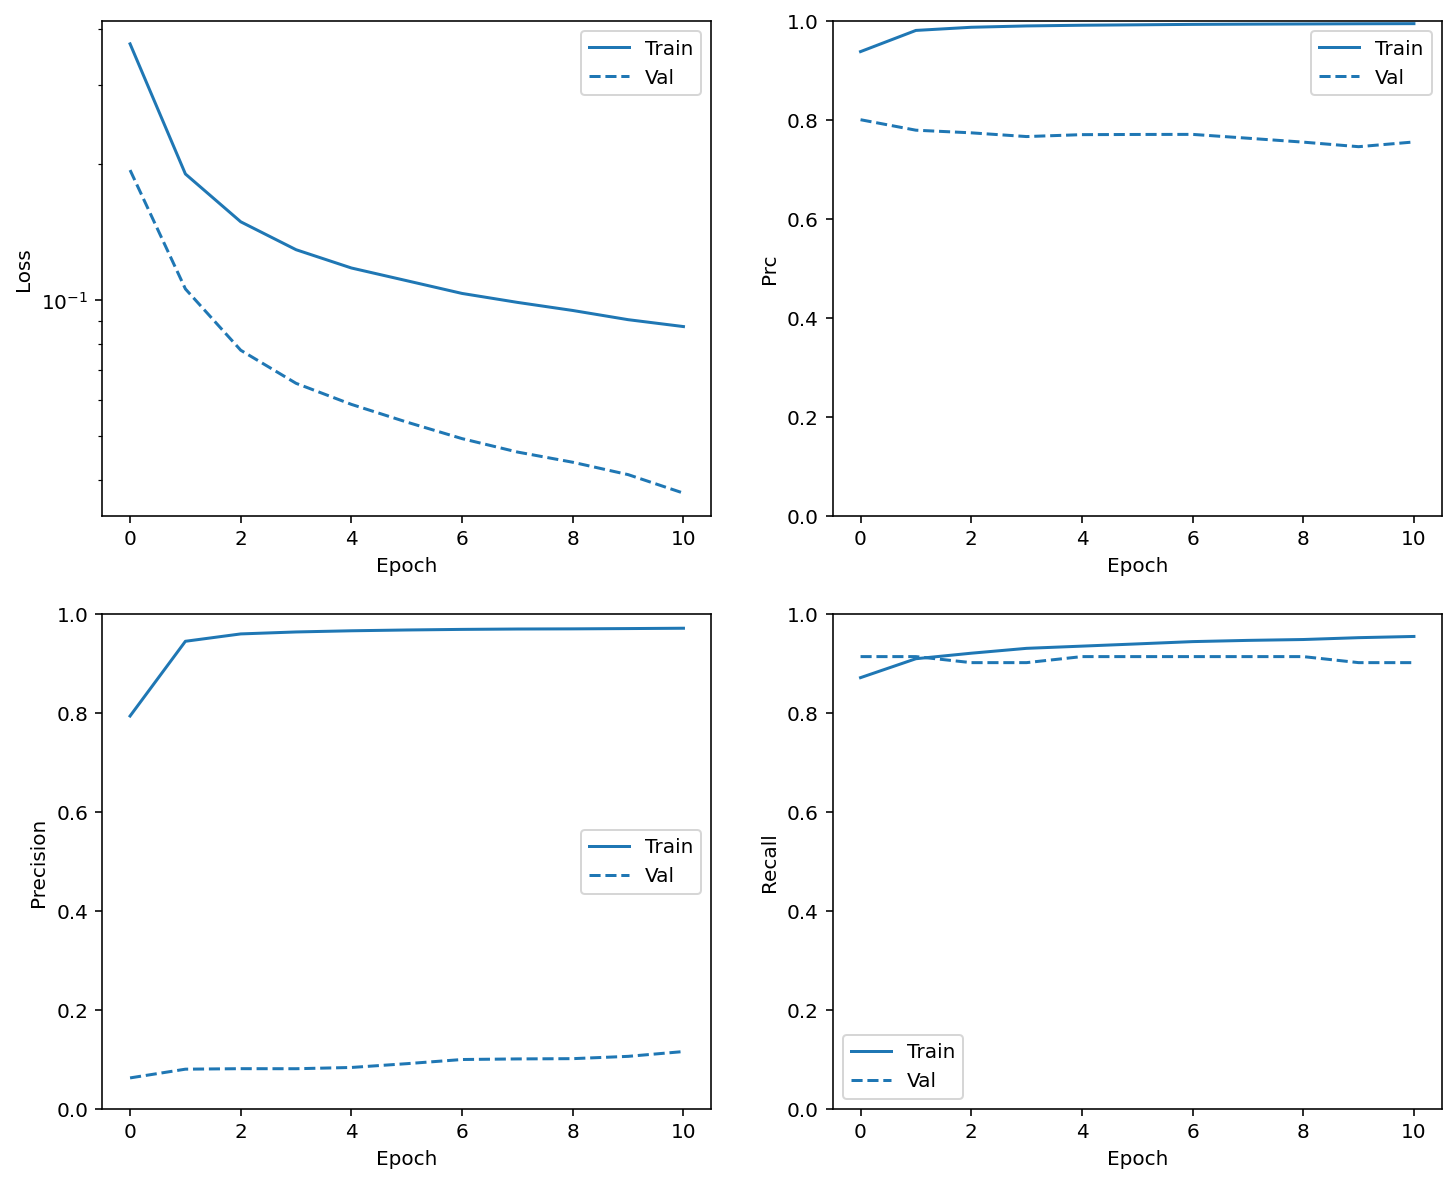

In [75]:
plot_metrics(resampled_history)

### Re-train

We train with larger number of epochs but making less steps per epoch to make sure that Early stopping can catch where to stop easier.

In [76]:
resampled_model_2 = make_model()
resampled_model_2.load_weights(initial_weights)

output_layer = resampled_model_2.layers[-1]
output_layer.bias.assign([0.0])

resampled_history_2 = resampled_model_2.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds)
)

Epoch 1/1000
20/20 [==============================] - 8s 229ms/step - loss: 0.7723 - tp: 13724.0000 - fp: 11464.0000 - tn: 54470.0000 - fn: 6871.0000 - accuracy: 0.7881 - precision: 0.5449 - recall: 0.6664 - auc: 0.8761 - prc: 0.7013 - val_loss: 0.7574 - val_tp: 75.0000 - val_fp: 24128.0000 - val_tn: 21359.0000 - val_fn: 7.0000 - val_accuracy: 0.4704 - val_precision: 0.0031 - val_recall: 0.9146 - val_auc: 0.8878 - val_prc: 0.3657
Epoch 2/1000
20/20 [==============================] - 2s 109ms/step - loss: 0.5815 - tp: 16667.0000 - fp: 9546.0000 - tn: 10835.0000 - fn: 3912.0000 - accuracy: 0.6714 - precision: 0.6358 - recall: 0.8099 - auc: 0.7935 - prc: 0.8402 - val_loss: 0.6650 - val_tp: 77.0000 - val_fp: 18263.0000 - val_tn: 27224.0000 - val_fn: 5.0000 - val_accuracy: 0.5991 - val_precision: 0.0042 - val_recall: 0.9390 - val_auc: 0.9314 - val_prc: 0.6008
Epoch 3/1000
20/20 [==============================] - 2s 115ms/step - loss: 0.4914 - tp: 17767.0000 - fp: 8166.0000 - tn: 12151.0000 

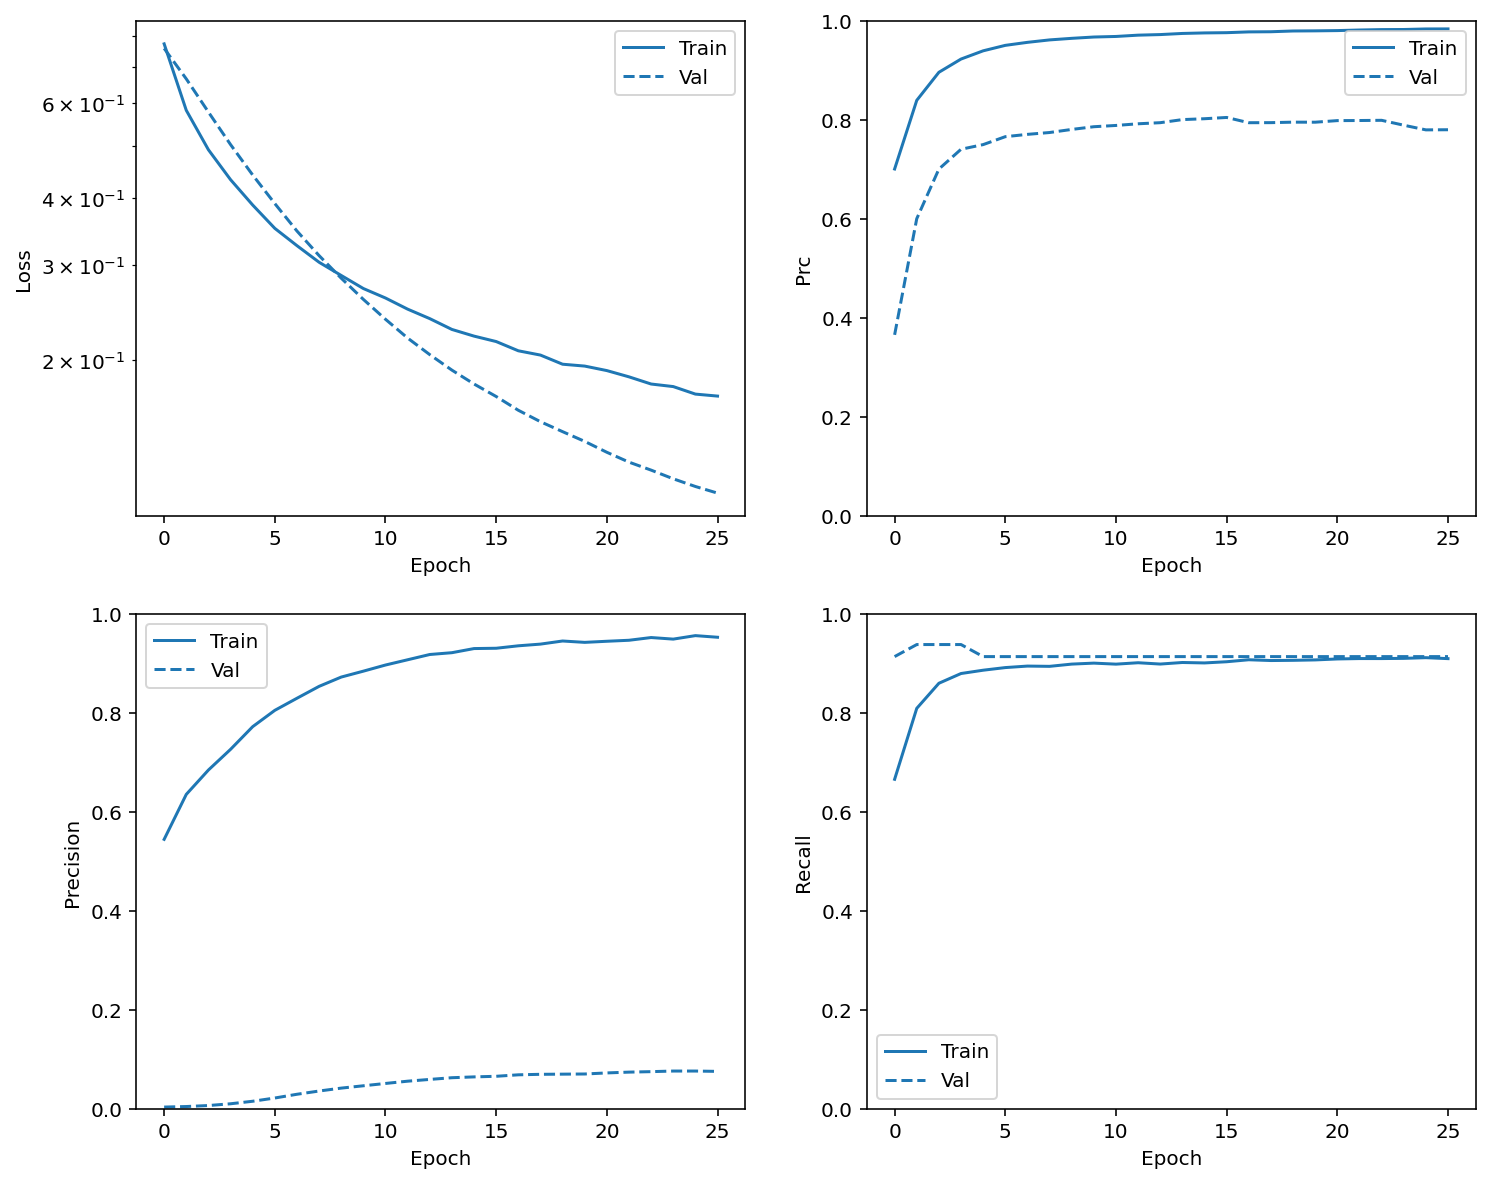

In [77]:
plot_metrics(resampled_history_2)

### Evaluate metrics

In [78]:
train_pred_resampled_2 = resampled_model_2.predict(train_features, batch_size=BATCH_SIZE)
test_pred_resampled_2 = resampled_model_2.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.1960618644952774
tp :  94.0
fp :  1473.0
tn :  55384.0
fn :  11.0
accuracy :  0.9739475250244141
precision :  0.05998723581433296
recall :  0.8952381014823914
auc :  0.9610779285430908
prc :  0.7284285426139832

Legitimate Transactions detected (TN):  55457
Legitimate tnxns incorrectly detecte (FP):  1400
Fraudulent tnxns missed (FN):  11
Fraudulent tnxns detected (TP):  94
Total fraudulent tnxns:  105


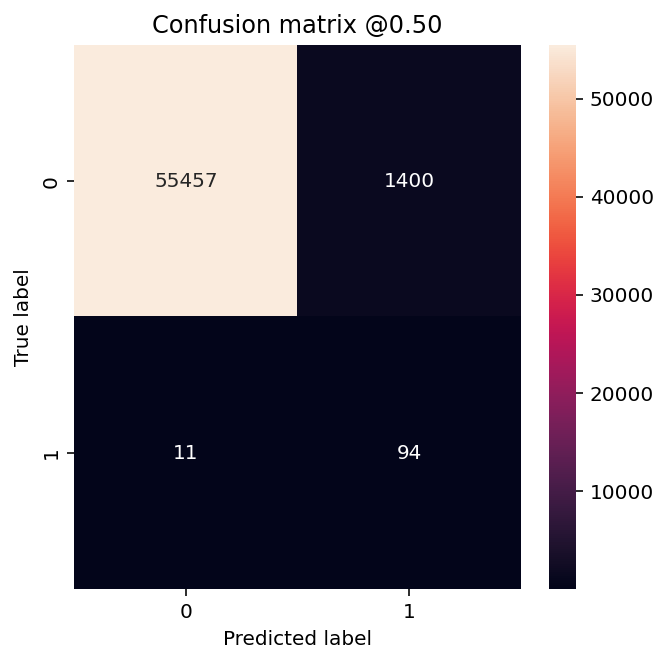

In [81]:
resampled_results_2 = resampled_model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0
)

for name, value in zip(resampled_model_2.metrics_names, resampled_results_2):
    print(name, ": ", value)
print()

plot_cm(test_labels, test_pred_resampled_2)

### Plot the ROC

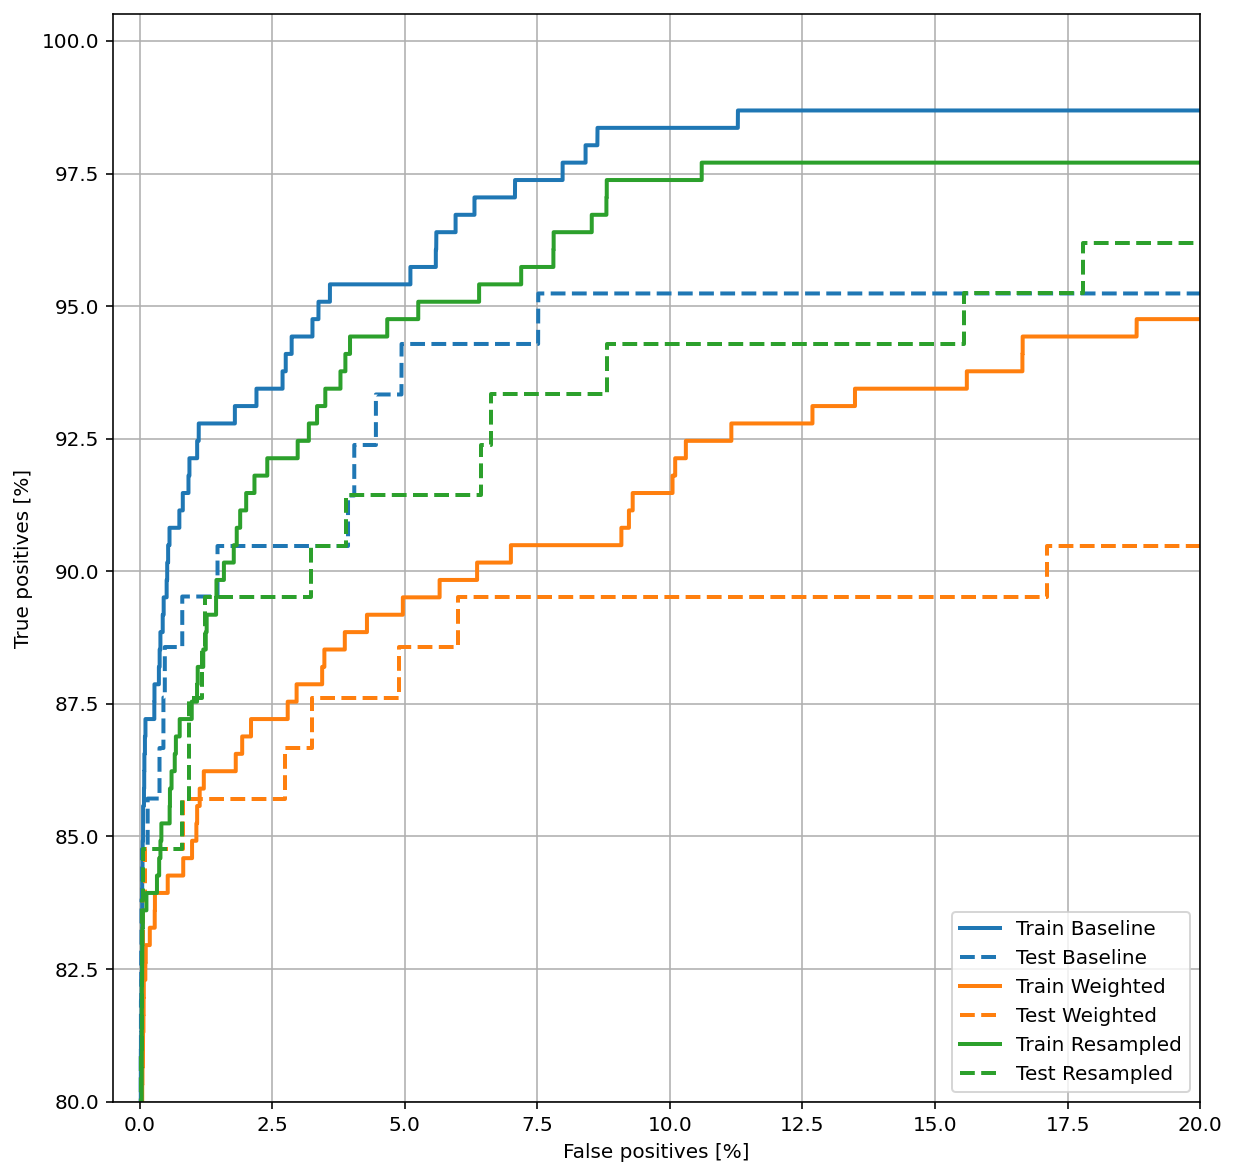

In [83]:
plot_roc("Train Baseline", train_labels, train_pred_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_pred_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_pred_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_pred_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_pred_resampled_2, color=colors[2])
plot_roc("Test Resampled", test_labels, test_pred_resampled_2, color=colors[2], linestyle='--')
plt.legend(loc='lower right');


### Plot the AUPRC

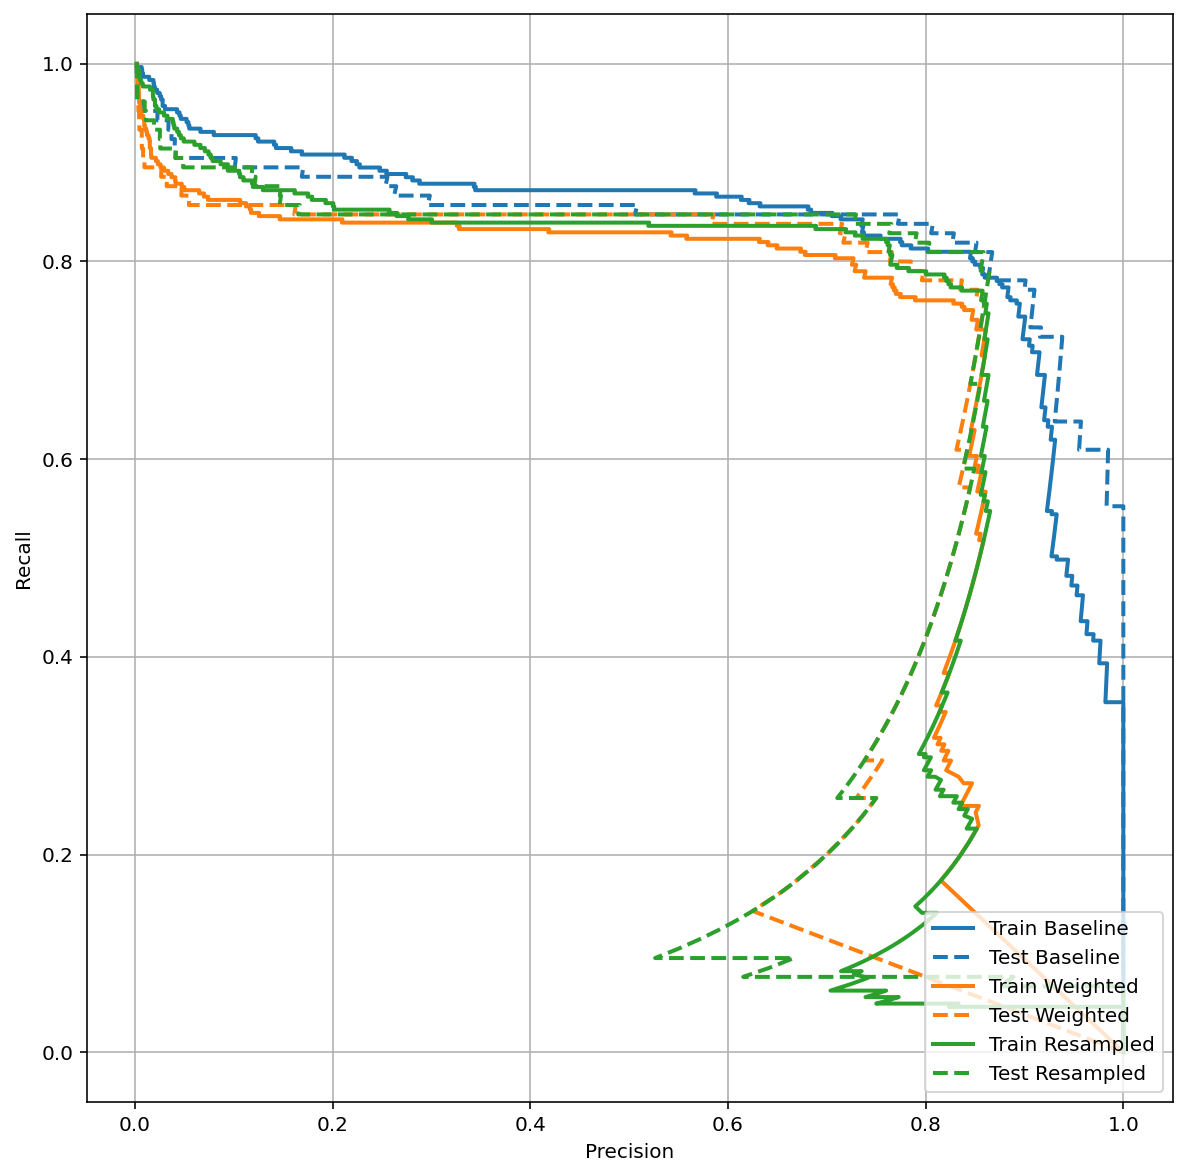

In [84]:
plot_prc("Train Baseline", train_labels, train_pred_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_pred_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_pred_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_pred_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_pred_resampled_2, color=colors[2])
plot_prc("Test Resampled", test_labels, test_pred_resampled_2, color=colors[2], linestyle='--')
plt.legend(loc='lower right');